# Import Packages

In [1]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 26.6 MB/s eta 0:00:00


In [2]:
import pybaseball
from pybaseball import statcast, statcast_batter, playerid_lookup, spraychart, statcast_sprint_speed, statcast_running_splits
from pybaseball.plotting import plot_bb_profile


'''
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, plot_roc_curve, roc_curve, auc, RocCurveDisplay, f1_score, recall_score, precision_score
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os.path
from os import path

import math

# Case Study: Corbin Carroll

Motivating some thought about how speed can affect ISO stats is the outlier speed of Arizona's Corbin Carroll. Just watching him easily take 3rd on line drives down the right field line made me think about how much his speed allows him to turn singles into double and doubles into triples more than the average baserunner. Inside-the-park home runs depend on much more than just a baserunner's speed alone, so I find the value in accounting for them to be too small to warrant including them.

I'll start by taking Carroll's small sample of batted balls that converted to hits and examining their distribution over the entire field.

## Data Gathering

In [3]:
# Statcast lookup
carroll_id = playerid_lookup('carroll','corbin')['key_mlbam'][0]

carroll = statcast_batter('2022-04-01', '2022-10-03', player_id = carroll_id)

#for i in carroll.columns:
#  print(i)

Gathering player lookup table. This may take a moment.
Gathering Player Data


In [4]:
hit_vars = ['description', 'des', 'events', 'hit_location', 'hit_distance_sc','bb_type', 'launch_speed_angle', 'hc_x', 'hc_y',
       'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
       'woba_value', 'woba_denom', 'iso_value',
       'launch_speed_angle','of_fielding_alignment', 
       'delta_home_win_exp', 'delta_run_exp']

In [5]:
# Return only balls in play, and then hits
carroll_BIP = carroll[hit_vars]
carroll_BIP = carroll_BIP[carroll_BIP['description'] == 'hit_into_play']
print('Dimensions (Balls in Play):', carroll_BIP.shape, '\n')

hits = ['triple','single','double','home_run']
carroll_hits = carroll_BIP[carroll_BIP['events'].isin(hits)]
print("Dimensions (Hits): " + str(carroll_hits.shape))

carroll_hits.head()

Dimensions (Balls in Play): (71, 18) 

Dimensions (Hits): (26, 18)


,description,des,events,hit_location,hit_distance_sc,bb_type,launch_speed_angle,hc_x,hc_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,iso_value,launch_speed_angle,of_fielding_alignment,delta_home_win_exp,delta_run_exp
0,hit_into_play,Corbin Carroll triples (2) on a sharp line dri...,triple,8.0,311.0,line_drive,5.0,146.66,75.19,0.806,0.841,1.60,1.0,2.0,5.0,Standard,-0.123,0.912
38,hit_into_play,Corbin Carroll singles on a ground ball to sho...,single,6.0,3.0,ground_ball,2.0,110.09,156.23,0.063,0.063,0.90,1.0,0.0,2.0,Standard,-0.068,0.637
44,hit_into_play,Corbin Carroll doubles (9) on a fly ball to le...,double,7.0,233.0,fly_ball,3.0,61.35,130.36,0.069,0.062,1.25,1.0,1.0,3.0,Standard,-0.046,0.633
45,hit_into_play,Corbin Carroll doubles (8) on a line drive to ...,double,9.0,233.0,line_drive,4.0,200.37,112.77,0.571,0.590,1.25,1.0,1.0,4.0,Standard,-0.028,0.261
69,hit_into_play,Corbin Carroll doubles (7) on a ground ball to...,double,8.0,20.0,ground_ball,2.0,139.46,97.17,0.260,0.234,1.25,1.0,1.0,2.0,Standard,-0.005,0.750


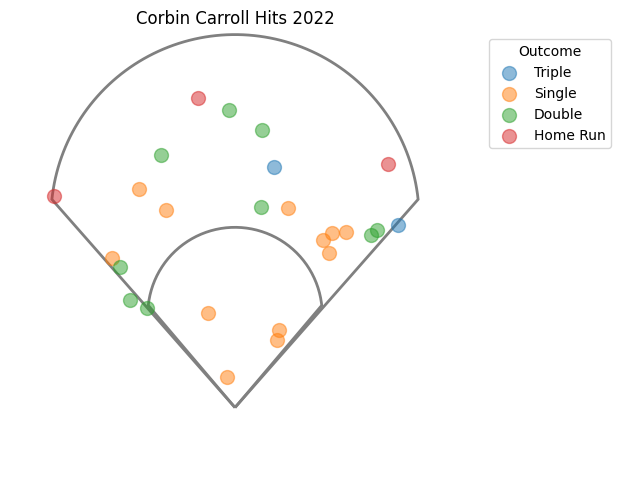

<Axes: title={'center': 'Corbin Carroll Hits 2022'}>

In [6]:
# Spraychart function
spraychart(carroll_hits, 'generic', title='Corbin Carroll Hits 2022')

## Normalizing Hit Coordinates via Linear Transformation

Going through the hit coordinate data and spraychart for Carroll, I noticed that the placement of each hit, their hit coordinates, and distance had varying discrepancies. I wasn't satisfied with taking the spraychart at its word, and devoted some time to recreating the spraychart output from "scratch," with the hit coordinates themselves. Specifically, I wanted to see how the hit coordinates in their requested form are translated to the points seen in a spraychart. This involved using some code to make a visualization of all the coordinate's transformation. A reference to how these coordiantes can be translated can be found at [r/Sabermetrics.](!https://www.reddit.com/r/Sabermetrics/comments/dbyw0r/hit_location_data/)

### Helper Functions

In [7]:
# Code taken from: https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html

# To animate the transform, we generate a series of intermediates
# Function to compute all intermediate transforms
def stepwise_transform(a, points, nsteps=30):
    '''
    Generate a series of intermediate transform for linear translation
      (hc_x - 130, 210 - hc_y)
    '''
    # create empty array of the right size
    transgrid = np.zeros((nsteps+1,) + np.shape(points))
    # compute intermediate transforms
    for j in range(nsteps+1):
        intermediate = j/nsteps*(np.asarray([130,210])) 
        #print(intermediate)
        transgrid[j] = np.asarray([[i - intermediate[0] for i in points[0]], [intermediate[1] - i for i in points[1]]]) # apply intermediate matrix transformation
    return transgrid

In [8]:
# Code taken from: https://dododas.github.io/linear-algebra-with-python/posts/16-12-29-2d-transformations.html

# Create a series of figures showing the intermediate transforms
def make_plots(transarray, color, outdir="png-frames", figuresize=(4,4), figuredpi=150):
    '''
    Generate a series of png images showing a linear transformation stepwise
    '''
    nsteps = transarray.shape[0]
    ndigits = len(str(nsteps)) # to determine filename padding
    maxval = np.abs(transarray.max()) # to set axis limits
    
    # create directory if necessary
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    # create figure
    plt.ioff()

    fig = plt.figure(figsize=figuresize, facecolor="w")
    for j in range(nsteps): # plot individual frames
        plt.cla()
        plt.scatter(transarray[j,0], transarray[j,1], s=36, c=color, edgecolor="none")
        plt.xlim(1.1*np.array([-maxval, maxval]))
        plt.ylim(1.1*np.array([-maxval, maxval]))
        plt.grid(True)
        plt.draw()
        # save as png
        outfile = os.path.join(outdir, "frame-" + str(j+1).zfill(ndigits) + ".png")
        fig.savefig(outfile, dpi=figuredpi)
    plt.ion()

In [9]:
# Code taken from: https://www.blog.pythonlibrary.org/2021/06/23/creating-an-animated-gif-with-python/

import glob
from PIL import Image

def make_gif(frame_folder, gif_name):
    '''
    Create a GIF sequencing all images in a directory together into a short clip
    '''
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(gif_name, format="GIF", append_images=frames,
               save_all=True, duration=500, loop=0)

### Make GIF for Changing Coordinate Values

Statcast hc_x and hc_y come in a strange form relative to how they are represented in a spray chart. In standard Cartesian coordinates, it appears as if (0,0) is the right field corner, and all the points as they are recorded are upside down. So to visualize exactly how you convert the raw hc_x and hc_y to the "correct" (Cartesian) values, all points need to be both flipped and translated to a new set of points, where home plate is the origin and all batted ball coordinates are found in the Quadrants 1 and 2. 

In [10]:
hit_coords = carroll_hits[['des','events','hc_x','hc_y','hit_distance_sc']]

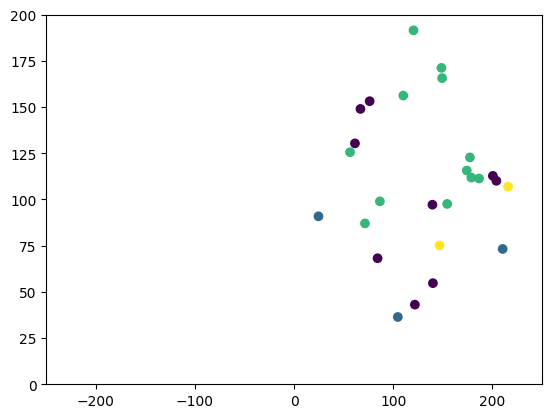

In [11]:
if path.exists('translation') == False:
  os.mkdir('translation')

scatter = plt.scatter(hit_coords['hc_x'],hit_coords['hc_y'], c = hit_coords.events.astype('category').cat.codes)
ax = scatter.axes
plt.xlim(-250,250)
plt.ylim(0,200)
plt.savefig('translation/1.png')


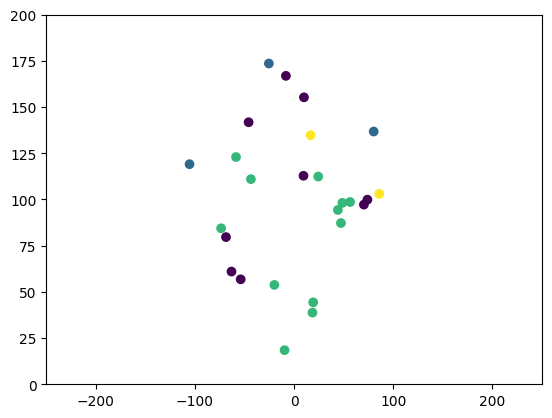

In [12]:
scatter2 = plt.scatter(hit_coords['hc_x'] - 130 ,210-hit_coords['hc_y'], c = hit_coords.events.astype('category').cat.codes)
ax2 = scatter2.axes
plt.xlim(-250,250)
plt.ylim(0,200)
plt.savefig('translation/2.png')

In [13]:
make_gif("translation", "translation.gif")

### Make GIF for point movement to (0,0)

In [14]:
# Sets starting and end points to perform translation, captured in several images
xy_points = np.asarray([hit_coords.hc_x, hit_coords.hc_y])
xy_trans = np.asarray([[i - 130 for i in xy_points[0]], [210 - i for i in xy_points[1]]])

# Apply to x-y grid
steps = 5
xy_transform = stepwise_transform(a = (130, 210), points = xy_points, nsteps=steps)

In [15]:
# Generate figures
make_plots(xy_transform, color = hit_coords.events.astype('category').cat.codes, outdir="transform_steps")

# Create GIF
make_gif("transform_steps", 'transformation.gif')

# Recreate Plots

## Cartesian

After performing the necessary translations, the Cartesian plane spraychart now makes a little more intutive sense. The spraychart from the pybaseball package is now reproduced below in standard matplotlib code.

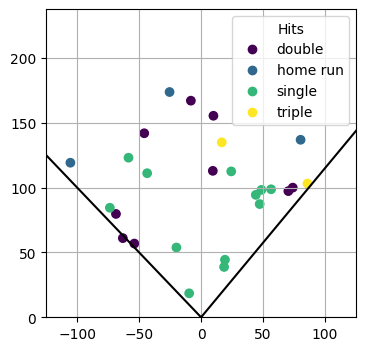

In [16]:
scatter = plt.scatter(hit_coords['hc_x'] - 130 ,210-hit_coords['hc_y'], c = hit_coords.events.astype('category').cat.codes)
ax = scatter.axes
plt.axline(xy1=(0.0,0.0),slope = 1.15, color = 'black')
plt.axline(xy1=(0.0,0.0),slope = -1, color = 'black')
plt.xlim(-125,125)
plt.ylim(bottom=0)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=['double','home run','single','triple'],
           title="Hits")
plt.show()

## Polar Coordinates

Previously, hit_distance_sc was used to plot the "r" value in polar coordinates. By using hit_distance_sc however, we get discrepancies in individual coordinates between a polar plot and the spraychart or Cartesian plot. However, we can solve for r directly by taking the hypotenuse of hc_x and hc_y gives r values that, in polar coordiantes, recreates the same plot seen in the spraychart() function and recreated Cartesian plot (with translations done on raw hc_x and hc_y).

In [17]:
# Takes - arctangent of translated x and y coordiantes (x/y), shifted by pi/2  to match appearance of spraychart
hit_coords['angle'] = (-1*np.arctan((hit_coords.hc_x - 130)/(210 - hit_coords.hc_y))) + (np.pi / 2)

# Given x and y, we calculate r value for polar coordiantes by simply taking hypotenuse of x and y
hit_coords['r'] = np.hypot((210 - hit_coords.hc_y),(hit_coords.hc_x - 130))

<ipython-input-17-a24e7edce62c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_coords['angle'] = (-1*np.arctan((hit_coords.hc_x - 130)/(210 - hit_coords.hc_y))) + (np.pi / 2)
<ipython-input-17-a24e7edce62c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_coords['r'] = np.hypot((210 - hit_coords.hc_y),(hit_coords.hc_x - 130))


In [18]:
hit_coords.head()

,des,events,hc_x,hc_y,hit_distance_sc,angle,r
0,Corbin Carroll triples (2) on a sharp line dri...,triple,146.66,75.19,311.0,1.447838,135.835532
38,Corbin Carroll singles on a ground ball to sho...,single,110.09,156.23,3.0,1.925423,57.337780
44,Corbin Carroll doubles (9) on a fly ball to le...,double,61.35,130.36,233.0,2.282218,105.144434
45,Corbin Carroll doubles (8) on a line drive to ...,double,200.37,112.77,233.0,0.944309,120.023372
69,Corbin Carroll doubles (7) on a ground ball to...,double,139.46,97.17,20.0,1.487149,113.225883


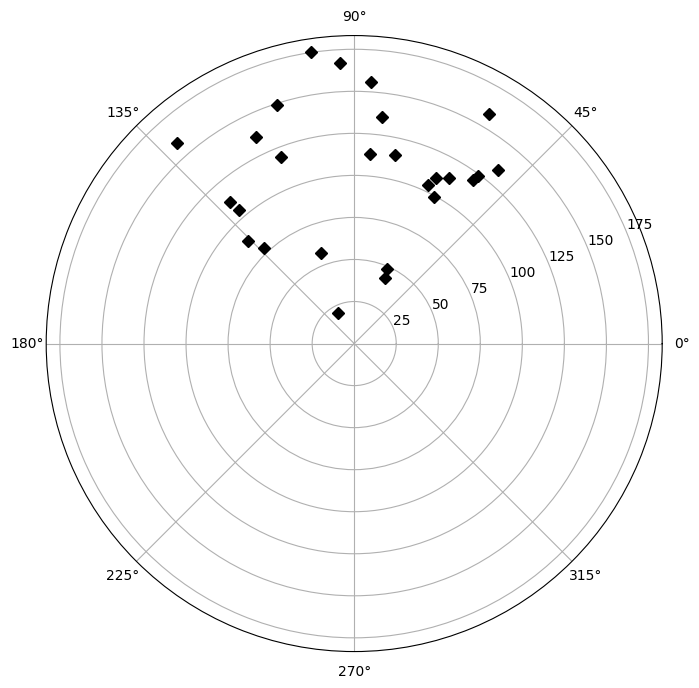

In [19]:
fig 	= plt.figure(figsize = (15,8))
ax	= fig.add_subplot(111, polar=True)

for x, y in zip(hit_coords.angle, hit_coords.r):
    ax.plot(x, y, 'kD')

## Calculating own distance metrics
We solved for the discrepancy between hit_distance_sc and final coordinates for hits by taking r-values instead, giving us a good representation of a spraychart in polar coordinates, with each batted ball represented in (r,theta) instead of (hc_x,h hc_y). We still have one more problem: the discrepancy between hit_distance_sc and the r-value itself. It should be noted that hit_distance_sc gives a value of the projected hit distance of a ball from the point it makes contact to when it first hits the ground. By comparing this with r-values, we get instances of hit_distance_sc being either far below or above r-values. How do we reconile these two?

I propose scaling all r-values up by a number that gives a close match to the total distance traveled as captured by the hc_x and hc_y coordiantes. Intutively, this means finding that scalar from calculating the proportion of distance in feet to r. Therefore, we have to look at instances where projected distance and hc_x and hc_y likely have little discrepancy, i.e. when a ball in play does not have to be tracked to see when it is picked up by a fielder, which is then tabulated as hc_x and hc_y. In conclusion, our scalar for r-values to distance can best be found in home runs, where what is tabulated by hc_x and hc_y is where the ball lands out of play, giving us a (crude but decent enough) proxy for total distance. Taking all home runs, dividing the Statcast projected distance by the r-value, averaging all quotients together, and applying this value to all other r-values gives an approximation for total distance traveled by balls in play that includes the distance traveled after it has bounced once.



In [20]:
# taking all home runs, average over the proportion of projected distance to r value
r_value_scalar = np.mean(hit_coords[hit_coords.events == 'home_run']['hit_distance_sc'] / hit_coords[hit_coords.events == 'home_run']['r'])
r_value_scalar

2.3204865722888006

In [21]:
# Scale up all values by r-value scalar to get better measure of total distance traveled
hit_coords['distance'] = hit_coords['r'] * r_value_scalar
hit_coords

<ipython-input-21-17621a9a766f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_coords['distance'] = hit_coords['r'] * r_value_scalar


,des,events,hc_x,hc_y,hit_distance_sc,angle,r,distance
0,Corbin Carroll triples (2) on a sharp line dri...,triple,146.66,75.19,311.0,1.447838,135.835532,315.204528
38,Corbin Carroll singles on a ground ball to sho...,single,110.09,156.23,3.0,1.925423,57.337780,133.051548
44,Corbin Carroll doubles (9) on a fly ball to le...,double,61.35,130.36,233.0,2.282218,105.144434,243.986248
45,Corbin Carroll doubles (8) on a line drive to ...,double,200.37,112.77,233.0,0.944309,120.023372,278.512623
69,Corbin Carroll doubles (7) on a ground ball to...,double,139.46,97.17,20.0,1.487149,113.225883,262.739140
95,Corbin Carroll singles on a soft ground ball t...,single,120.37,191.54,1.0,2.051628,20.820867,48.314542
135,Corbin Carroll singles on a sharp line drive t...,single,71.46,87.04,224.0,2.015133,136.184042,316.013240
164,Corbin Carroll doubles (6) on a sharp line dri...,double,139.94,54.72,319.0,1.506870,155.597821,361.062655
182,Corbin Carroll singles on a fly ball to right ...,single,174.11,115.67,219.0,1.133392,104.133765,241.641003
189,Corbin Carroll triples (1) on a line drive to ...,triple,215.76,106.97,219.0,0.876622,134.052074,311.066037


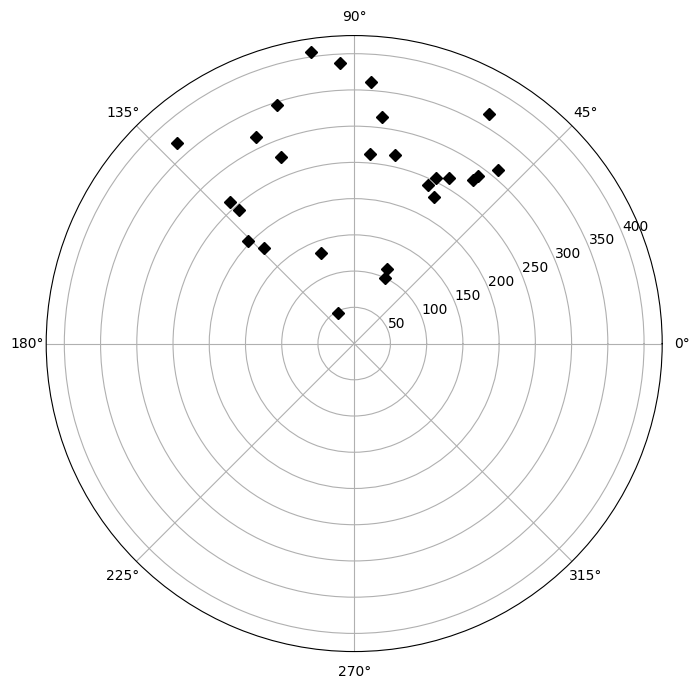

In [22]:
# Replot in polar coordiantes, with total distance
fig 	= plt.figure(figsize = (15,8))
ax	= fig.add_subplot(111, polar=True)

for x, y in zip(hit_coords.angle, hit_coords.distance):
    ax.plot(x, y, 'kD')

# Speed

In [23]:
sprint_data22 = statcast_running_splits(2022, 10, raw_splits = True)
speed_data22 = statcast_sprint_speed(2022, 10)

speed_data22

,last_name,first_name,player_id,team_id,team,position,age,competitive_runs,bolts,hp_to_1b,sprint_speed
0,Carroll,Corbin,682998,109,AZ,LF,21,52,31.0,4.05,30.7
1,Thompson,Bubba,669352,140,TEX,LF,24,60,44.0,4.16,30.4
2,Witt Jr.,Bobby,677951,118,KC,SS,22,201,107.0,4.13,30.4
3,Siri,Jose,642350,139,TB,CF,26,95,46.0,4.20,30.4
4,Turner,Trea,607208,119,LAD,SS,29,276,131.0,4.14,30.3
...,...,...,...,...,...,...,...,...,...,...,...
577,Cabrera,Miguel,408234,116,DET,DH,39,147,NaN,5.13,23.1
578,Pujols,Albert,405395,138,STL,DH,42,94,NaN,5.08,22.6
579,Maldonado,Martín,455117,117,HOU,C,35,95,NaN,5.07,22.4
580,Grandal,Yasmani,518735,145,CWS,C,33,94,NaN,5.26,22.0
